In [1]:
import numpy as np
import cv2
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pickle
from matplotlib import pyplot as plt
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy import ndimage as nd
from sklearn import metrics
from google.colab import files
from datetime import datetime 

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [3]:
!unzip sky
DATA_DIR = './sky/'
# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
 print('Please, upload the data!')

Archive:  sky.zip
replace sky/test/ann/0003_gt.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train/img')
y_train_dir = os.path.join(DATA_DIR, 'train/ann')
x_test_dir = os.path.join(DATA_DIR, 'test/img')
y_test_dir = os.path.join(DATA_DIR, 'test/ann')

In [5]:
ids = sorted(os.listdir(x_train_dir))
print(len(ids))
train_images_fps = [os.path.join(x_train_dir, image_id) for image_id in ids]
train_masks_fps = [os.path.join(y_train_dir, image_id.replace(".png","_gt.png")) for image_id in ids]

ids = sorted(os.listdir(x_test_dir))
print(len(ids))
test_images_fps = [os.path.join(x_test_dir, image_id) for image_id in ids]
test_masks_fps = [os.path.join(y_test_dir, image_id.replace(".png","_gt.png")) for image_id in ids]


48
10


In [6]:
train_images = []

for image in train_images_fps:
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(128,128))
  train_images.append(image)

#Convert list to array for machine learning processing        
train_images = np.array(train_images)


In [7]:
train_masks = []
for mask in train_masks_fps:
  mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
  mask=cv2.resize(mask,(128,128))
  ret, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY) 
  train_masks.append(mask)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks) 

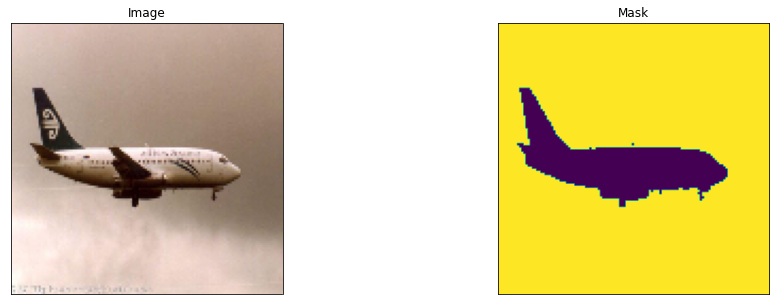

In [8]:
image=train_images[2] # get some sample
mask=train_masks[2]
visualize(
    image=image, 
    mask=mask
)

In [9]:
from keras.applications.vgg16 import VGG16
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
#y_train = np.expand_dims(y_train, axis=3)

In [10]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

In [11]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
from keras.models import Sequential, Model

#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


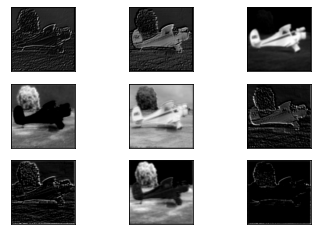

In [13]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

#Plot features to view them
square = 3
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [14]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
print(Y)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

#######here i skipped drop all 0
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']
print(np.unique(Y_for_RF))

[1 1 1 ... 0 0 0]
[1 0]
0    442281
1    344151
Name: Label, dtype: int64
[0 1]


In [15]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 45, random_state = 42,oob_score=True,max_depth=15)

start = datetime.now() 
model.fit(X_for_RF, Y_for_RF) 

stop = datetime.now() 

execution_time = stop-start
print("execution time is: ", execution_time)

execution time is:  0:04:48.185766


In [16]:
test_images = []

for image in test_images_fps:
  image = cv2.imread(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=cv2.resize(image,(128,128))
  test_images.append(image)

#Convert list to array for machine learning processing        
test_images = np.array(test_images)

test_masks = []

for mask in test_masks_fps:
  mask = cv2.imread(mask,cv2.IMREAD_GRAYSCALE)
  mask=cv2.resize(mask,(128,128))
  ret, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
  test_masks.append(mask)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks) 

In [17]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=2)  

X_test_feature=new_model.predict(test_images)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
y_test = np.expand_dims(test_masks, axis=3)
test_prediction = model.predict(X_test_feature)

IOU_keras.update_state(y_test, test_prediction)
print ("IOU on testing data = ", IOU_keras.result().numpy())

print ("IOU for each class on testing data:")
values = np.array(IOU_keras.get_weights()).reshape(2,2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]+ values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0]+ values[0,1])
print(class1_IoU)
print(class2_IoU)

train_prediction = model.predict(X_for_RF)

IOU_keras.update_state(Y_for_RF, train_prediction)
print ("IOU on training data = ", IOU_keras.result().numpy())

print ("IOU for each class on training data:")
values = np.array(IOU_keras.get_weights()).reshape(2,2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]+ values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0]+ values[0,1])
print(class1_IoU)
print(class2_IoU)


IOU on testing data =  0.8380941
IOU for each class on testing data:
0.8505310998300898
0.8256571748170124
IOU on training data =  0.9490902
IOU for each class on training data:
0.9547698901549201
0.9434104749741925


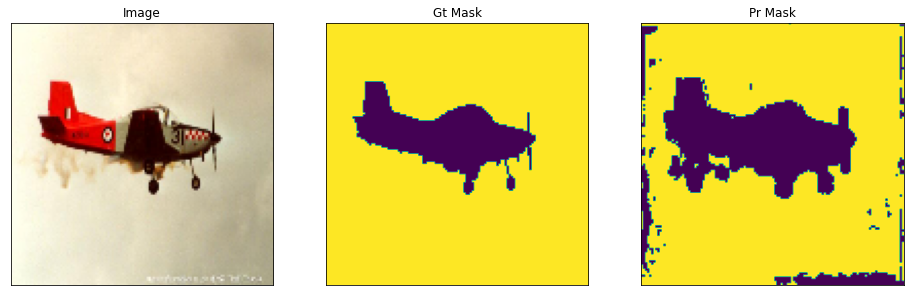

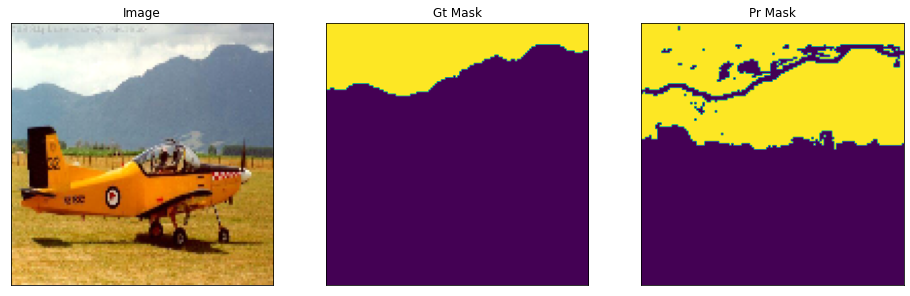

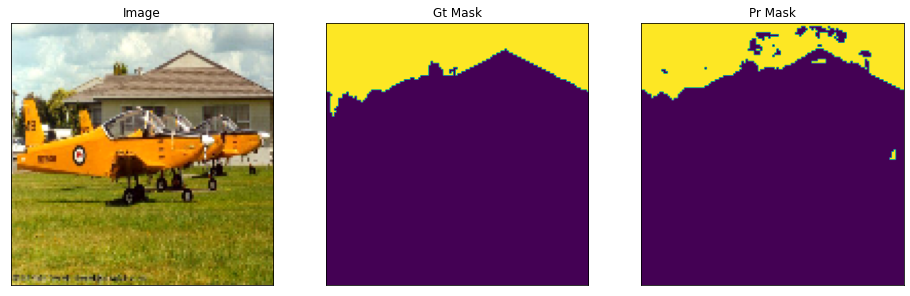

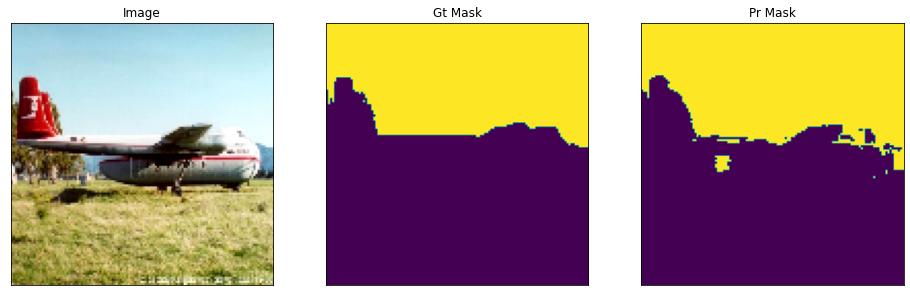

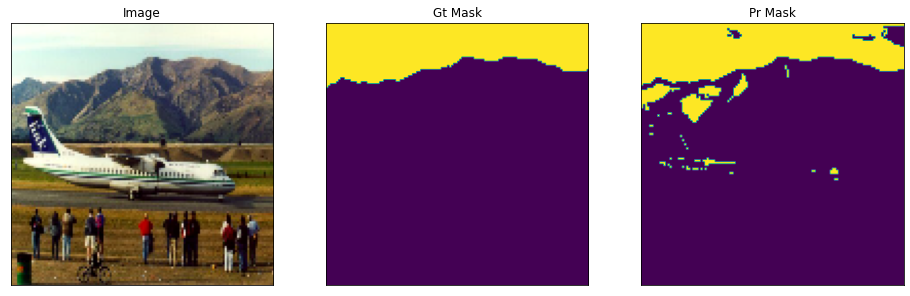

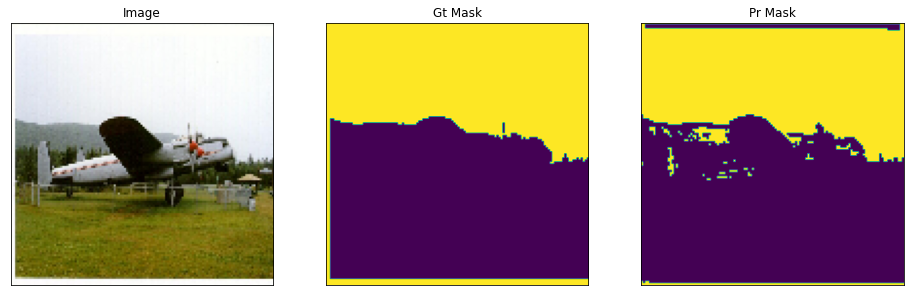

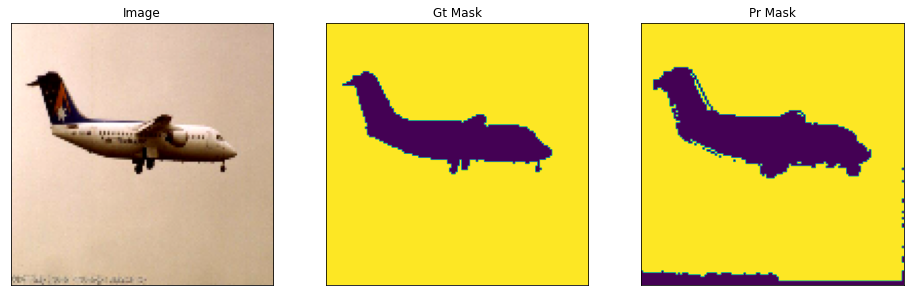

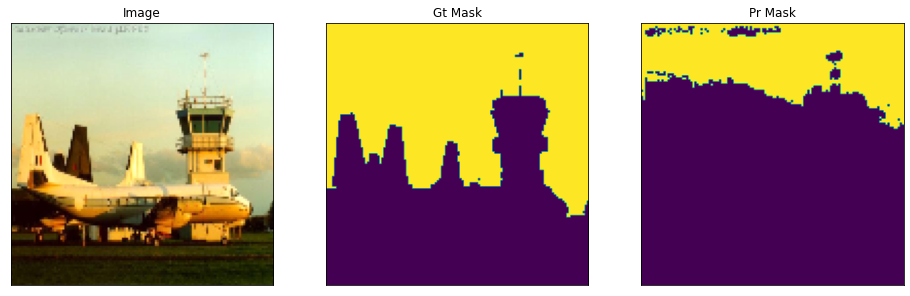

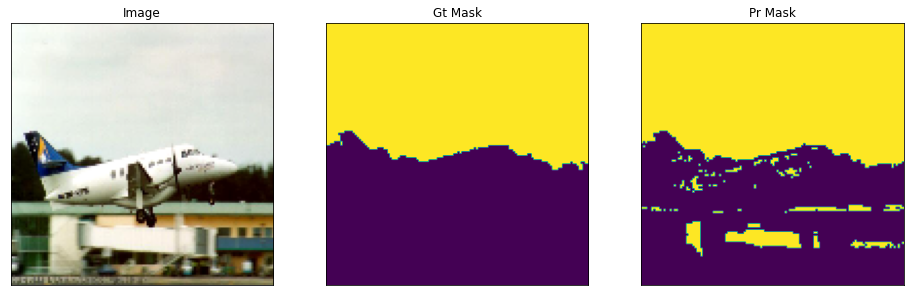

In [18]:
for i in range(0,9):
    
    image = test_images[i]
    gt_mask=test_masks[i]

    test_feature = np.expand_dims(image, axis=0)
    test_feature=new_model.predict(test_feature)
    test_feature = test_feature.reshape(-1, test_feature.shape[3])
    #gt_mask = np.expand_dims(gt_mask, axis=3)

    pr_mask = model.predict(test_feature)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.reshape(gt_mask.shape).squeeze(),
    )

In [19]:
#Save the trained model as pickle string to disk for future use
filename = "VGG_model_randomForest_cars_model"
pickle.dump(model, open(filename, 'wb'))

In [20]:
import pickle
loaded_model = pickle.load(open("VGG_model_randomForest_cars_model", 'rb'))